In [1]:
from contextlib import contextmanager
import os
import datetime as dt
import numpy as np
import h5py
import time
import sys
os.chdir('D:/software_git_repos/greenpol/telescope_control/data_aquisition')
sys.path.append('../')
sys.path.append('D:\\software_git_repos\\Polaris\\polaris_software\\utils_meinhold')
sys.path.append('D:\\software_git_repos\\Polaris\\polaris_software\\utils_zonca')
sys.path.append('D:\\software_git_repos\\Polaris\\polaris_software\\utils_zonca\\demod')
from glob import glob

sys.path.append('../../')
sys.path.append('../../../')
sys.path.append('../VtoT/')


import Tkinter,tkFileDialog

import cofe_util as cu
import realtime_gp as rt
import datetime

from Tkinter import *
import ttk

from scipy import optimize
import pickle


C:\Users\labuser\anaconda3\envs\py27\lib\site-packages\pyfits\__init__.py:22: PyFITSDeprecationWarning: PyFITS is deprecated, please use astropy.io.fits
  PyFITSDeprecationWarning)  # noqa


In [17]:
%matplotlib inline

In [18]:
def nametochan(name):
    #function to convert channel numbers to channel names

    #names of each channel
    chans = {
        'all': 'all',  'H1HiAC':'ch0',  'H1HiDC':'ch1',
        'H1LoAC':'ch2' ,  'H1LoDC':'ch3', 'H2HiAC':'ch4' ,
        'H2HiDC':'ch5' ,  'H2LoAC':'ch6',  'H2LoDC':'ch7',
        'H3HiAC':'ch8', 'H3HiDC':'ch9',  'H3LoAC':'ch10',
         'H3LoDC':'ch11', 'HornTop':'ch12', 'Amplifier': 'ch13',
        'Cooler':'ch14', 'Transition':'ch15'}

    chan = chans[name]

    return chan

In [3]:
%pylab

Using matplotlib backend: Qt5Agg
Populating the interactive namespace from numpy and matplotlib


C:\Users\labuser\anaconda3\envs\py27\lib\site-packages\IPython\core\magics\pylab.py:161: UserWarning: pylab import has clobbered these variables: ['Widget', 'Text', 'Button']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [4]:
def read_some_data(datadict,datalabel,datatype='demod', filelist=None):

    if filelist==None:
        root=Tkinter.Tk()
        if datatype=='demod':
            filelist = list(tkFileDialog.askopenfilenames(\
            initialdir='C://Greenland/greenpol/telescope_control/data_aquisition/demod_data/',parent=root,title='Choose a set of files'))
        if datatype=='raw':
            filelist = list(tkFileDialog.askopenfilenames(\
            initialdir='C://Greenland/greenpol/telescope_control/data_aquisition/data/',parent=root,title='Choose a set of files'))            
        root.destroy()
    filelist.sort()
    
    if datatype=='demod':
        dlist=[]
        for f in filelist:
            hf=h5py.File(f)
            dlist.append(hf['demod_data'])
        d=concatenate(dlist)
        hf.close() 
        
    if datatype=='raw':
        d=rt.demod.read_raw(filelist)
    datadict[datalabel]=d
    return

In [5]:
def plot_nl_dict(toi_dict,chanlist=['H1HiDC'],componentlist=['T'],datalist=None):
    #function to give a choice of preloaded datasets from dictionary data_dict
    #this plots chosen channels vs H1LoDC (should be attenuated more linear detector)
    figure()
    if datalist==None:
        datalist=toi_dict.keys()
    if len(componentlist)==1:  # if componentlist is a single value, assume same thing for all chans
        c=componentlist[0]
        componentlist=[c for n in chanlist]
    #set up the color sequence for the plot
    nlines=len(datalist)*len(chanlist)
    colormap = cm.gist_ncar
    gca().set_color_cycle([colormap(i) for i in np.linspace(0, 0.9, nlines)])
    titletxt=[]
    for dname in datalist:
        samprate=1000./(toi_dict[dname]['rev'][1]-toi_dict[dname]['rev'][0])
        print(dname,samprate)
        titletxt.append(dname)
        for channame,component in zip(chanlist,componentlist):
            print(channame,component)
            try:
                toi=toi_dict[dname][nametochan(channame)][component] #if it's demod data so a dict
                toi_x=toi_dict[dname][nametochan('H2LoDC')][component] #highly attenuated channel
                plot(toi_x,toi,label=dname+ '  '+channame+' '+component)
            except:
                toi=toi_dict[dname][nametochan(channame)].flatten()#if it's raw data so not a dict
                toi_x=toi_dict[dname][nametochan('H2LoDC')].flatten()# highly attenuated channel
                plot(toi_x,toi,label=dname+ '  '+channame+' '+component)
            
    title(titletxt)
    legend()
    xlabel('H1LoDC [V]')
    ylabel(r'Signal [V]')

In [6]:
#create a dictionary to hold relevant data, then read raw data files in for analysis
rdict={}

In [36]:
read_some_data(rdict,'nl2_3_22',datatype='raw')

1001
16


1000
16


1000
16


1000
16


1000
16


1000
16


1000
16


1000
16


1000
16


In [37]:
#plot for a quick check data are OK
#plot_nl_dict(rdict,chanlist=['H3HiDC', 'H1LoDC'],componentlist=['T'],datalist=['nl1_3_23'])

In [38]:
#d1=rdict['nl1_3_22'][nametochan('H1HiDC')].flatten()
#r1=rdict['nl1_3_22'][nametochan('H1LoDC')].flatten()
d2=rdict['nl2_3_22'][nametochan('H2HiDC')].flatten()
r2=rdict['nl2_3_22'][nametochan('H1LoDC')].flatten()
#d3=rdict['nl1_3_23'][nametochan('H3HiDC')].flatten()
#r3=rdict['nl1_3_23'][nametochan('H1LoDC')].flatten()

In [39]:
#isort=argsort(d1)
#ds1=d1[isort]
#rs1=r1[isort]
isort=argsort(d2)
ds2=d2[isort]
rs2=r2[isort]
#isort=argsort(d3)
#ds3=d3[isort]
#rs3=r3[isort]

In [40]:
def compfunc(x,p):
    """
    define a non-linear function to fit compression
    parameters p(4): (offset,slope,exponential coefficient, exponent)
    """
    y=p[0]+p[1]*x+p[2]*exp(p[3]*x)
    return y

def compfuncresiduals(p,y,x):
    err=y-compfunc(x,p)
    return err

In [41]:
def fit_compression(x,y,pstart=None):
    """
    function to fit compression function
    """
    xmax=x[y==np.max(y)][0]
    if pstart==None:
        pstart=[np.max(y),xmax,1,1]
        if np.max(y)==y[0]:
            pstart=[y[0],x[0]-1,0,1]
        if np.max(y)==y[-1]:
            pstart=[y[-1],x[-1]+1,1,0]
    pbest=optimize.leastsq(compfuncresiduals,pstart,args=(y,x))
    params={}
    params['offset']=pbest[0][0]
    params['slope']=pbest[0][1]
    params['exp_coeff']=np.abs(pbest[0][2])
    params['exponent']=np.abs(pbest[0][3])
    params['fit']=compfunc(x,pbest[0])
    return pbest[0]

In [42]:
def make_lookup(linpars,expars):
    #create lookup table for Vlin from Vexp
    x=arange(-.5,.1,.001)
    Vlin=(x-linpars[0])/linpars[1]
    Vexp=expars[0]+expars[1]*x+expars[2]*exp(expars[3]*x)
    return(Vexp,Vlin)

In [43]:
def linearize_Vexp(Vexp,lookup):
    #Vexp is input data, potentially compressed,lookup is lookup table (which is
    #a tuple of paired compressed and linearized values):
    # returns an array of estimated linear values
    Vlin=np.interp(Vexp,lookup[0],lookup[1])
    return Vlin 

In [44]:
#expars1=fit_compression(rs1,ds1)
expars2=fit_compression(rs2,ds2)
#expars3=fit_compression(rs3,ds3)

In [45]:
#dsf1=np.array([ds1[i] for i in range(len(ds1)) if (ds1[i]>-.5) and (ds1[i]<.04)])
#rsf1=np.array([rs1[i] for i in range(len(ds1)) if (ds1[i]>-.5) and (ds1[i]<.04)])
dsf2=np.array([ds2[i] for i in range(len(ds2)) if (ds2[i]>-.5) and (ds2[i]<.04)])
rsf2=np.array([rs2[i] for i in range(len(ds2)) if (ds2[i]>-.5) and (ds2[i]<.04)])

#dsf3=np.array([ds3[i] for i in range(len(ds3)) if (ds3[i]>-.5) and (ds3[i]<.04)])
#rsf3=np.array([rs3[i] for i in range(len(ds3)) if (ds3[i]>-.5) and (ds3[i]<.04)])

In [46]:
#linpars1=cu.linfit(dsf1,rsf1)
linpars2=cu.linfit(dsf2,rsf2)
#linpars3=cu.linfit(dsf3,rsf3)

In [47]:
#print(expars1)
#print(linpars1)
print(expars2)
print(linpars2)
#print(expars3)
#print(linpars3)

[-1.63474807 15.64453898  1.39352681 12.20774775]
[0.00710002 0.03012872]


In [48]:
#dsmod1=(rs1-linpars1[0])/linpars1[1]
dsmod2=(rs2-linpars2[0])/linpars2[1]
#dsmod3=(rs3-linpars3[0])/linpars3[1]


In [49]:
#store/save the linear and nonlinear fit parameters from 3/23/2018
expars1 = [-0.84993233 ,9.78598864,  0.66668683, 12.19587388]
linpars1 = [0.00956788, 0.05284956]
expars2 = [-1.63546518, 15.64129845,  1.3942447,  12.20374749]
linpars2 = [0.00710006, 0.03012924]
expars3 = [-0.46086952, 5.05960299,  0.39081414,  8.34334881]
linpars3 = [0.00771685, 0.12552887]


In [13]:
pars={'expars1':expars1,'expars2':expars2,'expars3':expars3, 'linpars1':linpars1,
     'linpars2':linpars2,'linpars3':linpars3}

fpath='D:/software_git_repos/greenpol/telescope_control/configurations'
#fpath='D:/software_git_repos/greenpol/telescope_control/configurations'
os.chdir(fpath)

folder='calibrations'

#get label for save file
fname='fit_params1'

os.chdir(fpath+'/'+folder)

if os.path.isfile(fname+'.txt')==True:
    print "LABEL EXISTS. Please change your label!"

else:
    with open(fname+'.txt', 'w') as handle:
        pickle.dump(pars,handle)
os.chdir('D:/software_git_repos/greenpol/telescope_control/data_aquisition')

it got here


In [50]:
#create lookup tables for linearizing
#lkp1=make_lookup(linpars1,expars1)
lkp2=make_lookup(linpars2,expars2)
#lkp3=make_lookup(linpars3,expars3)

In [51]:
#Vlin1=linearize_Vexp(ds1,lkp1)
Vlin2=linearize_Vexp(ds2,lkp2)
#Vlin3=linearize_Vexp(ds3,lkp3)

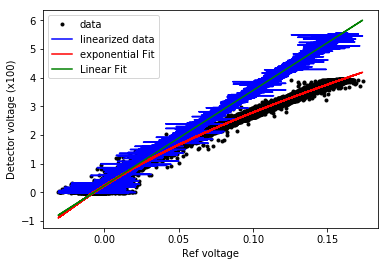

In [52]:
sign = -1
figure()
plot(sign*rs2,sign*ds2,'k.',label='data')
expmod2=compfunc(rs2,expars2)
#plot(sign*rsf2,sign*dsf2,label='data for linear fit')
plot(sign*rs2,sign*Vlin2, 'b-',label='linearized data')
plot(sign*rs2,sign*expmod2, 'r-',label='exponential Fit')
plot(sign*rs2,sign*dsmod2, 'g-',label='Linear Fit')
ylabel('Detector voltage (x100)')
xlabel('Ref voltage')
legend()

In [54]:
import realtime_gp as rt

In [55]:
Vlin_decreasing = rt.linearize_Vexp(ds2,2,params='_decreasing')
Vlin_increasing = rt.linearize_Vexp(ds2,2,params='_increasing')

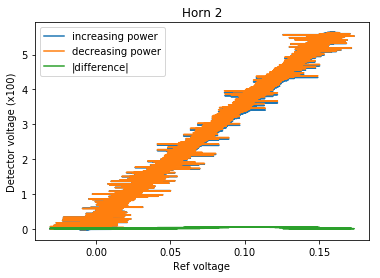

In [56]:
figure()
title('Horn 2')
plot(-rs2,-Vlin_decreasing,label='increasing power')
plot(-rs2,-Vlin_increasing,label='decreasing power')
plot(-rs2,abs(Vlin_increasing-Vlin_decreasing),label='|difference|')
ylabel('Detector voltage (x100)')
xlabel('Ref voltage')
legend()